In [1]:
!pip install timm
!pip install tensorboardX
!pip install einops

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import torch.nn.functional as F
import pandas as pd
from functools import partial
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.registry import register_model
import torch.utils.checkpoint as checkpoint

In [3]:
class CustomVideoDataset(Dataset):
    def __init__(self, video_folders_list, num_frames, frame_height, frame_width, frame_height_vivit, frame_width_vivit, num_frames_vivit):

        self.video_files_1 =  video_folders_list
        self.num_frames = num_frames
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.frame_height_vivit = frame_height_vivit
        self.frame_width_vivit = frame_width_vivit
        self.num_frames_vivit = num_frames_vivit

    def __len__(self):
        return len(self.video_files_1)

    def __getitem__(self, idx):
        optical_flow_video = 'Complete_Files_Optical_Together' +  '/' + self.video_files_1[idx] + '.mp4'
        romp_videos = 'Complete_Romp_Video_All_20_Frames_For_ViVit' + '/' + self.video_files_1[idx] + '.mp4'
        skelton_data = 'Complete_3D_Skeleton_Data_Star' + '/' + self.video_files_1[idx] + '.csv'
        

        video_path_1 = optical_flow_video
        video_path_2 = romp_videos
        Skeleton_path = skelton_data

        frames_1 = self._load_frames(video_path_1)
        frames_2 = self._load_frames_ViVit(video_path_2)
        data_3d = self._load_dataframe(Skeleton_path)

        video_action = '_'.join(self.video_files_1[idx].split('_')[:2])
        
        asd_action_label_str = self.video_files_1[idx].split('_')[-1][0]
        
        asd_action_label = int(asd_action_label_str)
        
        asd_action_label = torch.tensor(asd_action_label, dtype=torch.long)
        
        
        label = 0
        action_to_label = {
            'processed_Arm': 0, 'processed_bs': 1, 'processed_ce': 2, 'processed_dr': 3,
            'processed_fg': 4, 'processed_mfs': 5, 'processed_ms': 6,
            'processed_sq': 7, 'processed_tw': 8, 'processed_sac': 9, 'processed_tr': 10
        }
        
        label = action_to_label.get(video_action, label)
        label = torch.tensor(label, dtype=torch.long)

        return frames_1, frames_2, data_3d, label, asd_action_label

    def _load_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Explicitly convert to grayscale
            frame = cv2.resize(frame, (self.frame_width, self.frame_height))  # Resizing the frame
            frames.append(frame)
            if len(frames) == self.num_frames:
                break
        cap.release()

        # Handle case where video is shorter than num_frames
        while len(frames) < self.num_frames:
            frames.append(np.zeros((self.frame_height, self.frame_width), dtype=np.float32))  # Gray frame

        video_tensor = torch.tensor(np.stack(frames, axis=0)).unsqueeze(1).float() / 255  # Convert to torch tensor and normalize to [0,1]
        video_tensor = video_tensor.permute(1, 0, 2, 3)  # Reorder dimensions to [1, 16, 224, 224]

        return video_tensor
    
    def _load_frames_ViVit(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Explicitly convert to grayscale
            frame = cv2.resize(frame, (self.frame_width_vivit, self.frame_height_vivit))  # Resizing the frame
            frames.append(frame)
            if len(frames) == self.num_frames_vivit:
                break
        cap.release()

        # Handle case where video is shorter than num_frames
        while len(frames) < self.num_frames_vivit:
            frames.append(np.zeros((self.frame_width_vivit, self.frame_height_vivit), dtype=np.float32))  # Gray frame

        video_tensor = torch.tensor(np.stack(frames, axis=0)).unsqueeze(1).float() / 255  # Convert to torch tensor and normalize to [0,1]
        video_tensor = video_tensor.permute(1, 0, 2, 3)  # Reorder dimensions to [1, 16, 224, 224]

        return video_tensor
    
    
    def _load_dataframe(self, lstm_path):
        
        df = pd.read_csv(lstm_path)
        df = df.drop(['Action_Label', 'ASD_Label'], axis = 1)
        df_min = df.min().min()
        df_max = df.max().max()
        
        normalized_data = (df - df_min)/(df_max - df_min)
        
        data_array = normalized_data.values

        data_tensor = torch.tensor(data_array, dtype=torch.float)  
        return data_tensor
    
    
    
    
    

In [4]:
video_folder_optical_flow =  'Complete_Files_Optical_Together'
video_folder_romp = 'Complete_Romp_Video_All_20_Frames_For_ViVit'
lstm_table_data = 'Complete_3D_Skeleton_Data_Star'


list_files_optical_flow = os.listdir(video_folder_optical_flow)
list_files_lstm_data = os.listdir(lstm_table_data)
list_files_romp = os.listdir(video_folder_romp)

In [5]:
if '.ipynb_checkpoints' in list_files_optical_flow:
     list_files_optical_flow.remove('.ipynb_checkpoints')

In [6]:
if '.ipynb_checkpoints' in list_files_lstm_data:
     list_files_lstm_data.remove('.ipynb_checkpoints')

In [7]:
if '.ipynb_checkpoints' in list_files_romp:
     list_files_romp.remove('.ipynb_checkpoints')

In [8]:
for n in range(0, len(list_files_optical_flow)):
    list_files_optical_flow[n] = list_files_optical_flow[n].split('.')[0]

In [9]:
for n in range(0, len(list_files_lstm_data)):
    list_files_lstm_data[n] = list_files_lstm_data[n].split('.')[0]

In [10]:
for n in range(0, len(list_files_romp)):
    list_files_romp[n] = list_files_romp[n].split('.')[0]

In [11]:
list_files_optical_flow_0_1 = []
for n in range(0, len(list_files_optical_flow)):
    if list_files_optical_flow[n].split('_')[-1][0] == '1' or list_files_optical_flow[n].split('_')[-1][0] == '0':
        list_files_optical_flow_0_1.append(list_files_optical_flow[n])

In [12]:
len(list_files_optical_flow_0_1)

2565

In [13]:
set_optical_flow = set(list_files_optical_flow_0_1)
set_lstm_data = set(list_files_lstm_data)
set_romp = set(list_files_romp)

common_files = set_optical_flow & set_lstm_data & set_romp

# Convert the result back to a list if needed
common_files_list = list(common_files)

In [14]:
len(common_files_list)

2517

In [15]:
num_frames = 40
frame_height = 200
frame_width = 200
frame_height_vivit = 100
frame_width_vivit = 100
num_frames_vivit = 20

In [16]:
dataset = CustomVideoDataset(video_folders_list=common_files_list, num_frames=num_frames, frame_height=frame_height, frame_width=frame_width, frame_width_vivit = frame_width_vivit,frame_height_vivit = frame_height_vivit, num_frames_vivit = num_frames_vivit )

validation_split = 0.2
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset:
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
# ResNet3D Model
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=512):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        return x

def resnet3d():
    return ResNet3D(ResidualBlock, [2, 2, 2, 2])


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_optical = resnet3d().to(device)

In [27]:
class DropPath(nn.Module):

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None and init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=100, patch_size=10, in_chans=1, embed_dim=200, num_frames=20, tubelet_size=2):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.tubelet_size = int(tubelet_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (num_frames // self.tubelet_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv3d(in_channels=in_chans, out_channels=embed_dim,
                            kernel_size=(self.tubelet_size, patch_size[0], patch_size[1]),
                            stride=(self.tubelet_size, patch_size[0], patch_size[1]))

    def forward(self, x, **kwargs):
        B, C, T, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''
    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.tensor(sinusoid_table, dtype=torch.float, requires_grad=False).unsqueeze(0)

In [28]:

class PretrainVisionTransformerEncoder(nn.Module):
    def __init__(self, img_size=100, patch_size=10, in_chans=1, num_classes=0, embed_dim=200, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None, tubelet_size=2, use_checkpoint=False,
                 use_learnable_pos_emb=False, num_frames=20):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            num_frames=num_frames, tubelet_size=tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.use_checkpoint = use_checkpoint

        self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach()
        B, _, C = x.shape

        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
                x_vis = x
        else:
            for blk in self.blocks:
                x = blk(x)
                x_vis = x

        x_vis = self.norm(x_vis)
        return x_vis

    def forward(self, x):
        x = self.forward_features(x)
        #print(x.shape)
        #x = self.head(x)
        x = x.mean(dim=1)
        #x = self.mlp_head(x)
        return x

In [29]:
img_size = 100
patch_size = 10
in_chans = 1
num_classes = 11
embed_dim = 512
depth = 12
num_heads = 12
mlp_ratio = 4.0
qkv_bias = False
qk_scale = None
drop_rate = 0.0
attn_drop_rate = 0.0
drop_path_rate = 0.0
norm_layer = nn.LayerNorm
init_values = None
tubelet_size = 2
use_checkpoint = False
use_learnable_pos_emb = False
num_frames = 20



In [30]:
ViVit_Romp = PretrainVisionTransformerEncoder(
    img_size=img_size, patch_size=patch_size, in_chans=in_chans, num_classes=num_classes,
    embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
    qk_scale=qk_scale, drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=drop_path_rate,
    norm_layer=norm_layer, init_values=init_values, tubelet_size=tubelet_size, use_checkpoint=use_checkpoint,
    use_learnable_pos_emb=use_learnable_pos_emb, num_frames=num_frames)

In [32]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes= 1024):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 512)


    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

input_size = 75
hidden_size = 64
num_layers = 4
num_classes = 11



In [33]:
Skeleton_Lstm = LSTMModel(input_size, hidden_size, num_layers, num_classes)


In [48]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, query, key, value):
        B, N, C = query.shape
        head_dim = C // self.num_heads
        assert head_dim * self.num_heads == C, "embedding dimension must be divisible by num_heads"
        
        q = query.reshape(B, N, self.num_heads, head_dim).permute(0, 2, 1, 3)
        k = key.reshape(B, N, self.num_heads, head_dim).permute(0, 2, 1, 3)
        v = value.reshape(B, N, self.num_heads, head_dim).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x.mean(dim=1) 


class MultiModalModel(nn.Module):
    def __init__(self, img_size=100, patch_size=10, in_chans=1, num_classes=11, asd_classes=2, embed_dim=512, depth=12, num_heads=8, mlp_ratio=4.0, qkv_bias=False, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_values=None, tubelet_size=2, use_checkpoint=False, num_frames=20):
        super(MultiModalModel, self).__init__()
        num_heads=8

        self.optical_flow_model = cnn_optical  # Pretrained ViViT model
        self.romp_model = ViVit_Romp  # Pretrained CNN model
        self.lstm_model = Skeleton_Lstm  # Pretrained LSTM model

        optical_flow_dim = 512  # Assuming the output dimension of ViViT model
        romp_dim = 512  # Assuming the output dimension of CNN model
        lstm_dim = 512  # Assuming the output dimension of LSTM model

        assert optical_flow_dim % num_heads == 0, "Optical flow dimension must be divisible by the number of heads."
        assert romp_dim % num_heads == 0, "ROMP dimension must be divisible by the number of heads."
        
        self.attention_vivit = Attention(dim=lstm_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop_rate, proj_drop=drop_rate)
        self.attention_cnn = Attention(dim=lstm_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop_rate, proj_drop=drop_rate)
        
        combined_dim = lstm_dim * 2  # Since we will concatenate the outputs of both attention layers
        
        self.fc_fusion = nn.Linear(combined_dim, combined_dim)  # Fusion layer to combine both attention outputs
        self.fc_action = nn.Linear(combined_dim, num_classes)
        self.fc_asd = nn.Linear(combined_dim, asd_classes)

    def forward(self, optical_flow, romp, lstm_skeleton):
        optical_flow_features = self.optical_flow_model(optical_flow).unsqueeze(1)  # [B, 1, 512]
        romp_features = self.romp_model(romp).unsqueeze(1)  # [B, 1, 512]
        lstm_features = self.lstm_model(lstm_skeleton).unsqueeze(1)  # [B, 1, 1024]
        print(optical_flow_features.shape)
        print(romp_features.shape)
        print(lstm_features.shape)
        
        # Using lstm_features as Q and V for both attention heads, and optical_flow_features/romp_features as K
        attended_vivit = self.attention_vivit(query=lstm_features, key=optical_flow_features, value=lstm_features)
        attended_cnn = self.attention_cnn(query=lstm_features, key=romp_features, value=lstm_features)
        
        # Combine the outputs of both attention heads
        combined_features = torch.cat((attended_vivit, attended_cnn), dim=-1)  # [B, 1024 + 1024]
        
        fused_features = self.fc_fusion(combined_features)
        
        action_logits = self.fc_action(fused_features)
        asd_logits = self.fc_asd(fused_features)
        
        return action_logits, asd_logits


In [50]:
model = MultiModalModel(
    img_size=img_size, patch_size=patch_size, in_chans=in_chans, num_classes=num_classes,
    embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
    qk_scale=qk_scale, drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=drop_path_rate,
    norm_layer=norm_layer, init_values=init_values, tubelet_size=tubelet_size, use_checkpoint=use_checkpoint,
    num_frames=num_frames
)

In [51]:
model.to(device)

MultiModalModel(
  (optical_flow_model): ResNet3D(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): BatchNorm3d(64,

In [54]:
alpha = 0.5  # Coefficient for action classification loss
beta = 0.5   # Coefficient for ASD classification loss


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
criterion_action = nn.CrossEntropyLoss()
criterion_asd = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100

all_predicted_action = []
all_true_action = []
all_predicted_asd = []
all_true_asd = []

for epoch in range(num_epochs):
    model.train()
    running_loss_action = 0.0
    running_loss_asd = 0.0
    for optical, romp, lstm, labels, asd_labels in train_loader:
        optical, romp, labels, asd_labels = optical.to(device), romp.to(device), labels.to(device), asd_labels.to(device)
        lstm = lstm.to(device)
        optimizer.zero_grad()

        action_outputs, asd_outputs = model(optical, romp, lstm)
        loss_action = criterion_action(action_outputs, labels)
        loss_asd = criterion_asd(asd_outputs, asd_labels)
        
        # Weight the losses
        loss = alpha * loss_action + beta * loss_asd
        loss.backward()
        optimizer.step()

        running_loss_action += loss_action.item()
        running_loss_asd += loss_asd.item()

    model.eval()
    val_loss_action = 0.0
    val_loss_asd = 0.0
    correct_action = 0
    total_action = 0
    correct_asd = 0
    total_asd = 0

    with torch.no_grad():
        for optical, romp, lstm, labels, asd_labels in val_loader:
            optical, romp, labels, asd_labels = optical.to(device), romp.to(device), labels.to(device), asd_labels.to(device)
            lstm = lstm.to(device)
            action_outputs, asd_outputs = model(optical, romp, lstm)
            loss_action = criterion_action(action_outputs, labels)
            loss_asd = criterion_asd(asd_outputs, asd_labels)
            val_loss_action += loss_action.item()
            val_loss_asd += loss_asd.item()

            _, predicted_action = torch.max(action_outputs.data, 1)
            total_action += labels.size(0)
            correct_action += (predicted_action == labels).sum().item()

            _, predicted_asd = torch.max(asd_outputs.data, 1)
            total_asd += asd_labels.size(0)
            correct_asd += (predicted_asd == asd_labels).sum().item()

            # Store predictions and true labels
            all_predicted_action.extend(predicted_action.cpu().numpy())
            all_true_action.extend(labels.cpu().numpy())
            all_predicted_asd.extend(predicted_asd.cpu().numpy())
            all_true_asd.extend(asd_labels.cpu().numpy())

    train_loss_action = running_loss_action / len(train_loader)
    train_loss_asd = running_loss_asd / len(train_loader)
    val_loss_action = val_loss_action / len(val_loader)
    val_loss_asd = val_loss_asd / len(val_loader)
    val_accuracy_action = 100 * correct_action / total_action
    val_accuracy_asd = 100 * correct_asd / total_asd
    

    print(f"Epoch [{epoch}/{num_epochs}], Train Loss Action: {train_loss_action:.4f}, Train Loss ASD: {train_loss_asd:.4f}, "
          f"Validation Loss Action: {val_loss_action:.4f}, Validation Loss ASD: {val_loss_asd:.4f}, "
          f"Validation Accuracy Action: {val_accuracy_action:.2f}%, Validation Accuracy ASD: {val_accuracy_asd:.2f}%")


torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])


In [58]:
# Convert lists to numpy arrays
all_predicted_action = np.array(all_predicted_action)
all_true_action = np.array(all_true_action)
all_predicted_asd = np.array(all_predicted_asd)
all_true_asd = np.array(all_true_asd)

# Calculate metrics for action classification
accuracy_action = accuracy_score(all_true_action, all_predicted_action)
precision_action = precision_score(all_true_action, all_predicted_action, average='weighted')
recall_action = recall_score(all_true_action, all_predicted_action, average='weighted')
f1_action = f1_score(all_true_action, all_predicted_action, average='weighted')
conf_matrix_action = confusion_matrix(all_true_action, all_predicted_action)

# Calculate metrics for ASD classification
accuracy_asd = accuracy_score(all_true_asd, all_predicted_asd)
precision_asd = precision_score(all_true_asd, all_predicted_asd, average='weighted')
recall_asd = recall_score(all_true_asd, all_predicted_asd, average='weighted')
f1_asd = f1_score(all_true_asd, all_predicted_asd, average='weighted')
conf_matrix_asd = confusion_matrix(all_true_asd, all_predicted_asd)

print(f"Action Classification - Accuracy: {accuracy_action:.4f}, Precision: {precision_action:.4f}, Recall: {recall_action:.4f}, F1-score: {f1_action:.4f}")
print(f"ASD Classification - Accuracy: {accuracy_asd:.4f}, Precision: {precision_asd:.4f}, Recall: {recall_asd:.4f}, F1-score: {f1_asd:.4f}")

print("Confusion Matrix for Action Classification:")
print(conf_matrix_action)
print("Confusion Matrix for ASD Classification:")
print(conf_matrix_asd)


Action Classification - Accuracy: 0.3439, Precision: 0.3048, Recall: 0.3439, F1-score: 0.3119
ASD Classification - Accuracy: 0.5865, Precision: 0.5864, Recall: 0.5865, F1-score: 0.5827
Confusion Matrix for Action Classification:
[[11  5  3  1  0  0 10  3  0  1  3]
 [14  6  5  1  0  0  9  4  0  0  8]
 [ 9  6  8  5  0  0  8  2  0  0  5]
 [ 0  0  0 32 12  0  3  3  2 10  1]
 [ 0  0  0  2 20  0  0  0  4  2  0]
 [ 6  5  1  2  0  0 28  0  0  2  2]
 [ 5 13  2  2  0  0 27  2  0  1  4]
 [ 1  0  3 23  2  0  2  8  2  3  5]
 [ 0  0  0  1  2  0  0  0 31  2  0]
 [ 0  0  0 19  5  0  0  2  7 16  4]
 [ 1  3  4  7  0  0  9  1  3  3 14]]
Confusion Matrix for ASD Classification:
[[176  84]
 [124 119]]


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


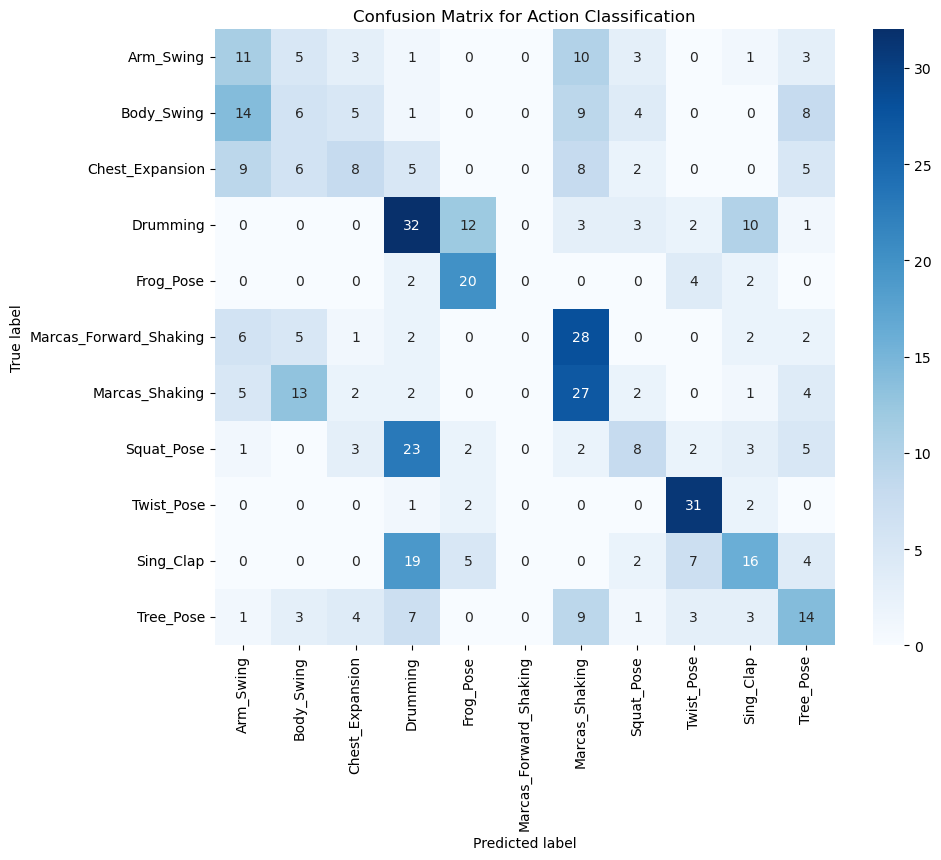

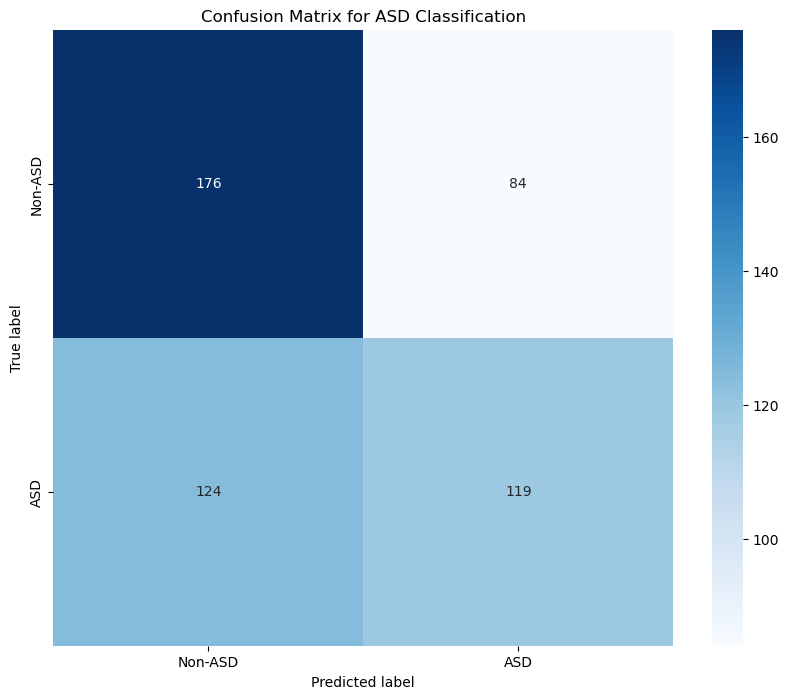

In [59]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Define class names
action_classes = ['Arm_Swing', 'Body_Swing', 'Chest_Expansion', 'Drumming', 'Frog_Pose', 'Marcas_Forward_Shaking', 'Marcas_Shaking', 'Squat_Pose', 'Twist_Pose', 'Sing_Clap', 'Tree_Pose']

asd_classes = ['Non-ASD', 'ASD']

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_action, action_classes, title='Confusion Matrix for Action Classification')
plot_confusion_matrix(conf_matrix_asd, asd_classes, title='Confusion Matrix for ASD Classification')
